In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


data_path = "data/car_data.csv"

In [2]:
def load_data(data_path):
    return pd.read_csv(data_path)

def data_cleaning(data):
    data["Model"] = data["Model"].str.replace("5-Sep", "9-5")
    data["Model"] = data["Model"].str.replace("3-Sep", "9-3")
    data["Date"] = pd.to_datetime(data["Date"], format="%m/%d/%Y")
    return data

In [3]:
data_raw = load_data(data_path)
data_cleaned = data_cleaning(data_raw)

In [4]:
def feature_engineering(data):
    data["Year"] = data["Date"].dt.year
    data["Month"] = data["Date"].dt.month
    data["Quarter"] = data["Date"].dt.quarter
    data["Weekday"] = data["Date"].dt.weekday

    # Aggregate past sales per brand
    data["Sales Count"] = data.groupby(["Company", "Date"])["Car_id"].transform("count")

    # Lag features (previous sales trends)
    data = data.sort_values(by=["Company", "Date"])
    data["Previous_Month_Sales"] = data.groupby("Company")["Sales Count"].shift(1)
    data["Previous_3Month_Avg"] = data.groupby("Company")["Sales Count"].rolling(3).mean().shift(1).reset_index(0, drop=True)
    
    data["Price_to_Income_Ratio"] = data["Price ($)"] / data["Annual Income"]

    # Fill missing values (due to shifts)
    data.fillna(0, inplace=True)

    return data

In [5]:
data_before_fe = data_cleaned.copy()

data_fe = feature_engineering(data_cleaned)

In [6]:
def normalize_features(data, features):
    scaler = MinMaxScaler()
    data[features] = scaler.fit_transform(data[features])
    return data, scaler

In [7]:
features = ["Previous_Month_Sales", "Previous_3Month_Avg", "Price ($)", "Annual Income"]
data_normalized, scaler = normalize_features(data_fe, features)

In [8]:
def create_lstm_sequences(df, time_steps=3):
    X, y = [], []
    for i in range(len(df) - time_steps):
        X.append(df.iloc[i : i + time_steps].values)
        y.append(df.iloc[i + time_steps]["Sales Count"])
    return np.array(X), np.array(y)

In [9]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, activation="relu"),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
    return model

In [10]:
def train_lstm_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=16):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    return model

In [11]:
from sklearn.model_selection import train_test_split

X, y = create_lstm_sequences(data_normalized[features + ["Sales Count"]], time_steps=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

model = train_lstm_model(model, X_train, y_train, X_test, y_test)

Epoch 1/50


/Users/edvard/relu/sales_prediction_exploration/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1196/1196 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 11.0668 - val_loss: 2.6123
Epoch 2/50
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6173 - val_loss: 2.2504
Epoch 3/50
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0383 - val_loss: 2.0648
Epoch 4/50
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8991 - val_loss: 1.9086
Epoch 5/50
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8065 - val_loss: 1.8052
Epoch 6/50
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6614 - val_loss: 1.7397
Epoch 7/50
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6129 - val_loss: 1.6834
Epoch 8/50
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3151 - val_loss: 1.6638
Epoch 9/50
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.3399 - val_loss: 1.6170
Epoch 10/50
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2835 - val_loss: 1.5998
Epoch 11/50
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.3612 - val_loss: 1.7124
Epoch 12/50
1196/1196 ━━━━━━━━━━━━━━━━━━

In [12]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(y_test)), y_test, label="Actual", marker="o", s=10)
    plt.scatter(range(len(y_test)), y_pred, label="Predicted", marker="x", s=10, alpha=0.3)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Sales Count")
    plt.title("Actual vs Predicted Sales Count")
    plt.show()

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


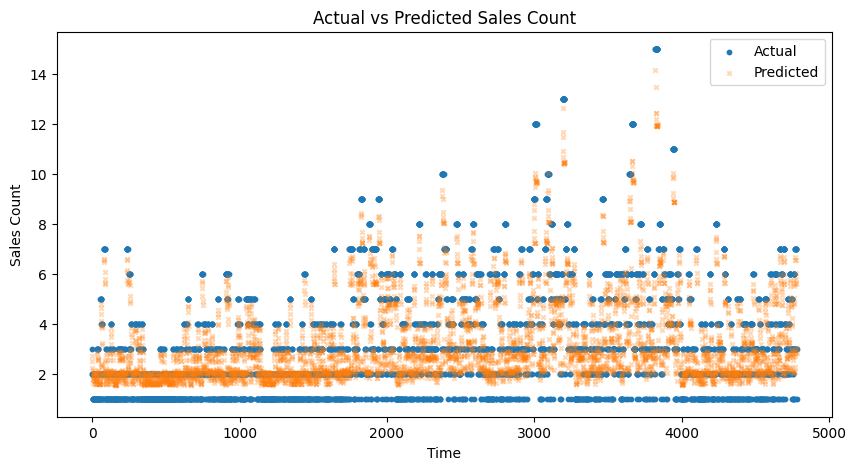

In [13]:
evaluate_model(model, X_test, y_test)

In [14]:
rmse = np.sqrt(np.mean((y_test - model.predict(X_test))**2))

print(f"RMSE: {rmse}")

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
RMSE: 2.8483868135570463
